### Time Travel Matrix Traveling Between Cook County Census Tracts

**Data Requirements to Build**

To create a time_travel_matrix, we need 3 inputs:
- list of origin points
- road network, open street maps file
- public transport schedule

**Origin Points**

In [3]:
import geopandas
import pygris

In [4]:
#get tracks for Cook County
tracts = pygris.tracts(state="17", county="031").loc[:,['GEOID', 'geometry']]
tracts

Using the default year of 2021


,GEOID,geometry
54,17031221000,"POLYGON ((-87.71699 41.92460, -87.71675 41.924..."
55,17031221100,"POLYGON ((-87.71374 41.92464, -87.71366 41.924..."
56,17031242800,"POLYGON ((-87.69670 41.89565, -87.69646 41.895..."
57,17031242900,"POLYGON ((-87.68684 41.89574, -87.68635 41.895..."
58,17031243000,"POLYGON ((-87.68195 41.89583, -87.68146 41.895..."
...,...,...
3210,17031050300,"POLYGON ((-87.69476 41.96127, -87.69460 41.961..."
3218,17031830700,"POLYGON ((-87.66595 41.96164, -87.66575 41.961..."
3219,17031834700,"POLYGON ((-87.65002 41.79424, -87.64986 41.794..."
3254,17031824123,"POLYGON ((-87.81369 41.60198, -87.81287 41.601..."


In [5]:
def get_origin_points(tracts):
    '''
    Gets origin points for a dataframe of census tracts (or could be any geography).

    Inputs:
    - tracts (pandas DF): contains a column 'geometry' which is the geometry of the tract.

    Returns (pandas DF): origins, dataframe with 5 additional columns, one named 'origin' 
        which is the centroid if it is within the polygon and the representative
        point otherwise.
    '''  
    output = tracts.copy()
    
    # add centroid, point on surface, and boolean values if centroid is within the tract
    origins = geopandas.GeoDataFrame(output)
    origins.loc[:,'CENTROID'] = origins.loc[:,'geometry'].centroid
    origins.loc[:,'centroid_in_tract'] = origins.loc[:,'geometry'].contains(origins.loc[:,'CENTROID'])
    origins.loc[:,'REPRESENTATIVE_POINT'] = origins.loc[:,'geometry'].representative_point()
    origins.loc[:,'rpoint_in_tract'] = origins.loc[:,'geometry'].contains(origins.loc[:,'REPRESENTATIVE_POINT'])

    # set origin as centroid if in tract, else set representative point
    origins.loc[:,'ORIGIN'] = origins.loc[:,'CENTROID']
    origins.loc[(origins.loc[:,'centroid_in_tract'] == False),'ORIGIN'] = origins.loc[:,'REPRESENTATIVE_POINT']

    return origins

In [6]:
tracts_gdf = get_origin_points(tracts)
tracts_gdf

/tmp/user/23050/ipykernel_1263962/1772240468.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  origins.loc[:,'CENTROID'] = origins.loc[:,'geometry'].centroid


,GEOID,geometry,CENTROID,centroid_in_tract,REPRESENTATIVE_POINT,rpoint_in_tract,ORIGIN
54,17031221000,"POLYGON ((-87.71699 41.92460, -87.71675 41.924...",POINT (-87.71525 41.92096),True,POINT (-87.71525 41.92096),True,POINT (-87.71525 41.92096)
55,17031221100,"POLYGON ((-87.71374 41.92464, -87.71366 41.924...",POINT (-87.71036 41.92102),True,POINT (-87.71036 41.92109),True,POINT (-87.71036 41.92102)
56,17031242800,"POLYGON ((-87.69670 41.89565, -87.69646 41.895...",POINT (-87.69032 41.89263),True,POINT (-87.68922 41.89201),True,POINT (-87.69032 41.89263)
57,17031242900,"POLYGON ((-87.68684 41.89574, -87.68635 41.895...",POINT (-87.68429 41.89220),True,POINT (-87.68429 41.89215),True,POINT (-87.68429 41.89220)
58,17031243000,"POLYGON ((-87.68195 41.89583, -87.68146 41.895...",POINT (-87.67940 41.89228),True,POINT (-87.67940 41.89232),True,POINT (-87.67940 41.89228)
...,...,...,...,...,...,...,...
3210,17031050300,"POLYGON ((-87.69476 41.96127, -87.69460 41.961...",POINT (-87.69152 41.95768),True,POINT (-87.69146 41.95763),True,POINT (-87.69152 41.95768)
3218,17031830700,"POLYGON ((-87.66595 41.96164, -87.66575 41.961...",POINT (-87.65917 41.96098),True,POINT (-87.65796 41.96174),True,POINT (-87.65917 41.96098)
3219,17031834700,"POLYGON ((-87.65002 41.79424, -87.64986 41.794...",POINT (-87.64503 41.79069),True,POINT (-87.64508 41.79068),True,POINT (-87.64503 41.79069)
3254,17031824123,"POLYGON ((-87.81369 41.60198, -87.81287 41.601...",POINT (-87.80355 41.59123),True,POINT (-87.80354 41.59110),True,POINT (-87.80355 41.59123)


Why we used both the representative point and the centroid: 

In [7]:
# 11 instances where the centroid is not in the census tract 
(tracts_gdf.loc[:,'centroid_in_tract'] == False).sum()

11

Makes sense - all of these census tracts have weird shapes.

<Axes: >

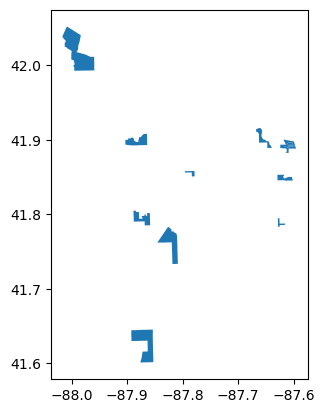

In [8]:
tracts_gdf[(tracts_gdf.loc[:,'centroid_in_tract'] == False)].plot()

**Open Street Maps/Road Networks**

Now, we need the two remaining data types -- a road network from open street maps (.pbf file) 

First, for road network we have two package options
- pydriosm: https://pydriosm.readthedocs.io/en/latest/quick-start.html#download-data
- pyrosm: https://pyrosm.readthedocs.io/en/latest/basics.html#protobuf-file-what-is-it-and-how-to-get-one


OSM
- pbf file 
- hierarchy - tags
    key/value pairs
    all street networks highway
        parse that down by the values - to extract that if you only want a specific part

    geometry types
        points, line strings, polygons - multi line strings, and multi polygons
    geometry collection
        combinations of the types

.pbf - supply key/values and the geometry types
    highways are always line strings
    


In [9]:
#geofabric - .pbf file - osmium to parse the .pbf file - to parse that
    #download smaller extracts
#amazon has osm file - updated osm universe 
    #download the planet

import pyrosm 

# Download the data into specified directory
fp = pyrosm.get_data("Illinois", directory="travel_time_matrix/tracts_17_031")
print("Data was downloaded to:", fp)

Data was downloaded to: /home/ckboyd/mansueto/chicago-model/travel_time_matrix/tracts_17_031/illinois-latest.osm.pbf


**Public transport schedule (general transit feed specification format)**

In [10]:
#find & save GTFS zip files to input folder
import os
import shutil
import urllib

DIRECTORY = "travel_time_matrix/tracts_17_031"

if not os.path.exists(DIRECTORY):
   # Create a new directory if it doesn't exist
   os.makedirs(DIRECTORY)

In [11]:
def read_zip_to_disc(url, filepath):
    '''
    Saves url zip file to local folder filepath.

    Inputs:
    - url (string): Ends in .zip
    - filepath (string): path you want your zip saved to

    Returns: None. Saves the zip to the folder.
    '''
    # request the file from website
    req = urllib.request.Request(url)

    # open it in a file and write it to save it in local
    with urllib.request.urlopen(req) as response, open(filepath, 'wb') as f:
        shutil.copyfileobj(response, f)

In [13]:
# read CTA GTFS
read_zip_to_disc(url='http://www.transitchicago.com/downloads/sch_data/google_transit.zip',
                 filepath="travel_time_matrix/tracts_17_031/cta_chicago.zip")

In [15]:
from gtfslite import GTFS
cta_gtfs = GTFS.load_zip("travel_time_matrix/tracts_17_031/cta_chicago.zip")

In [16]:
cta_gtfs.summary()

agencies            [Chicago Transit Authority]
total_stops                               11177
total_routes                                131
total_trips                               46357
total_stops_made                        2662834
first_date                             20231108
last_date                              20240131
total_shapes                             636410
dtype: object

**Pull into r5py**

In [1]:
import r5py

#create transport network with osm.pbf and GTFS by pointing to the directory with all relevant files
transport_network = r5py.TransportNetwork.from_directory("travel_time_matrix/tracts_17_031")

In [9]:
origins_small = tracts_gdf[['GEOID','ORIGIN']].rename(columns={'GEOID':'id',
                                                         'ORIGIN':'geometry'}).iloc[:10, :]
destinations_small = tracts_gdf[['GEOID','ORIGIN']].rename(columns={'GEOID':'id',
                                                              'ORIGIN':'geometry'}).iloc[:10, :]

In [10]:
import datetime

travel_time_matrix = r5py.TravelTimeMatrixComputer(
    transport_network,
    origins=origins_small,
    destinations=destinations_small,
    transport_modes=[r5py.TransportMode.CAR],
    departure=datetime.datetime(2023, 10, 13, 8, 0, 0) #Monday 10/13/23 8AM,
).compute_travel_times()

In [ ]:
origins_small.to_csv("origins_small.csv")

In [11]:
travel_time_matrix

,from_id,to_id,travel_time
0,17031221000,17031221000,0
1,17031221000,17031221100,0
2,17031221000,17031242800,8
3,17031221000,17031242900,8
4,17031221000,17031243000,9
...,...,...,...
95,17031071400,17031243100,10
96,17031071400,17031243200,10
97,17031071400,17031243300,9
98,17031071400,17031243400,8


In [12]:
wide_travel_time_matrix = travel_time_matrix.pivot(index="from_id", columns="to_id", values="travel_time")

In [16]:
wide_travel_time_matrix

to_id,17031071400,17031221000,17031221100,17031242800,17031242900,17031243000,17031243100,17031243200,17031243300,17031243400
from_id,,,,,,,,,,
17031071400,1,13,13,12,11,11,10,10,9,8
17031221000,12,0,0,8,8,9,9,10,10,9
17031221100,11,0,0,7,7,8,9,9,9,9
17031242800,14,8,7,0,2,3,3,4,4,5
17031242900,13,8,7,1,0,1,1,2,3,4
17031243000,12,9,8,3,0,0,0,1,3,3
17031243100,12,9,8,3,1,0,0,0,2,3
17031243200,12,10,9,3,1,1,0,0,2,3
17031243300,11,10,10,4,3,3,2,2,0,0


In [15]:
tract_of_interest = "17031221000"

travel_times_to_tract = travel_time_matrix[travel_time_matrix["from_id"] == tract_of_interest].copy()
travel_times_to_tract = travel_times_to_tract.set_index("from_id")[["travel_time"]]

tracts_with_travel_time_to_tract = (
    tracts_gdf.set_index("id").join(travel_times_to_tract)
)

tracts_with_travel_time_to_tract

KeyError: "None of ['id'] are in the columns"

In [ ]:
tracts_with_travel_time_to_tract.explore(
    column="travel_time",
    cmap="YlOrBr",
    tiles="CartoDB.Positron",
)